今回は線形関数近似の探索でよく出てくる[Improved Algorithms for Linear Stochastic Bandits](https://papers.nips.cc/paper/4417-improved-algorithms-for-linear-stochastic-bandits)を学びます。

前回も線形バンディットをやりましたが([contextual_bandit.ipynb](contextual_bandit.ipynb))、詳しい証明やよりよいバンディットについては触れてませんでした。
線形バンディットやLilnear MDPでタイトな性能を達成するためには、今回紹介する"self-normalized bound for vector-balued martingale"ってやつが大事になってきます。

--- 
**定理：Self-Normalized Bound for Vector Valued Martingales**

$\left\{F_t\right\}_{t=0}^{\infty}$をフィルトレーションとする。 
$\left\{\eta_t\right\}_{t=1}^{\infty}$を$\eta_t$が$F_t$-可測な実数値確率過程とする。また、$\eta_t$は条件付き$R$-sub-Gaussianとする ($R \geq 0$)。つまり、
$$
\forall \lambda \in \mathbb{R} \quad \mathbf{E}\left[e^{\lambda \eta_t} \mid F_{t-1}\right] \leq \exp \left(\frac{\lambda^2 R^2}{2}\right)
$$

$\left\{X_t\right\}_{t=1}^{\infty}$は$X_t$が$F_{t-1}$-可測である$\mathbb{R}^d$の確率過程とする。
$V$を$d \times d$の正則行列とする。任意の$t \geq 0$について、
$$
\bar{V}_t=V+\sum_{s=1}^t X_s X_s^{\top} \quad S_t=\sum_{s=1}^t \eta_s X_s .
$$
すると、任意の$\delta>0$について、最低でも確率$1-\delta$で、任意の$t \geq 0$について、
$$
\left\|S_t\right\|_{\bar{V}_t^{-1}}^2 \leq 2 R^2 \log \left(\frac{\operatorname{det}\left(\bar{V}_t\right)^{1 / 2} \operatorname{det}(V)^{-1 / 2}}{\delta}\right)
$$
が成り立つ。

---

ここで、マルチンゲールのぶれ$\left\|S_t\right\|_{\bar{V}_t^{-1}}^2$が$\bar{V}_t^{-1}$で測られていることに注意しましょう。
つまり、マルチンゲールのぶれ自体がマルチンゲールから出てきた量で測られているのでself-normalizedと呼ばれるんですね。
証明はちょっと厄介なので論文を参考にしてください。(式展開を追うとなるほど！となりますが、分かりやすい説明はTODOです。)

これを確認してみましょう。

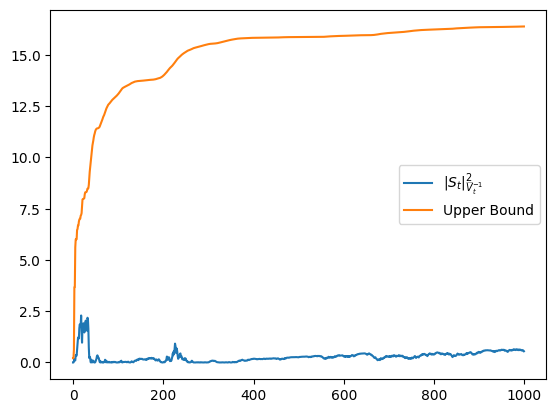

In [102]:
import numpy as np
import matplotlib.pyplot as plt

d = 10
length = 1000
R = 1
lam = 0.1  # V用のパラメータです
delta = 0.9  # 信頼パラメータです

# etaはR-sub gaussianにします
etas = (np.random.rand(length) - 0.5) * 2 * R
# X用に適当な確率過程を作っておきます
F = np.zeros((length, d))
for i in range(d):
    F[:, i] = etas * i

# Vは適当な正則行列です。今回はlambda * eyeとします。
V = 1 * np.eye(d)
S_t_norms = []
upper_bound = []
Xs = np.zeros((length, d))
for t in range(length):
    # Xは適当に時刻t-1から予想できるF_{t-1}-measurableな値にします
    if t == 0:
        pass
    else:
        Xs[t] = F[:t].sum(axis=0)

    V_t = V.copy()
    S_t = np.zeros(d)
    for i in range(t):
        X = Xs[i].reshape(d, 1)
        V_t += X @ X.T
        S_t += etas[i] * Xs[i]
    assert S_t.shape == (d,)

    # ノルムを計算します
    S_t_norms.append(S_t @ np.linalg.inv(V_t) @ S_t)

    # 上界を計算します
    y = np.log(np.sqrt(np.linalg.det(V_t)) / np.sqrt(np.linalg.det(V)) / delta)
    upper_bound.append(2 * R ** 2 * y)

plt.plot(S_t_norms, label=r"$\|S_t\|^2_{\widebar{V}_t^{-1}}$")
plt.plot(upper_bound, label=r"Upper Bound")
plt.legend()

さて、このバウンドを使った線形バンディットについて考えてみましょう。

行動の集合として$\mathcal{D}_t \subset \mathbb{R}^d$ を考えて、その中から一つ行動$X_t \in \mathcal{A}_t$ を選択することを考えます。そして、報酬関数が次の形をしている状況を考えます:

$$
Y_t = \langle X_t, \theta_*\rangle + \eta_t
$$

ここで$\eta_t$は$R$-subgaussianです。以下、次の擬リグレットを考えます：

$$
R_n =\sum_{t=1}^n \left\langle x_t^* - X_t, \theta_* \right\rangle
$$

ここで$x_t^* = \mathrm{argmax}_{x_\in D_t} \langle x_t, \theta_* \rangle$です。
リグレットを定義したので、以下では[contextual_bandit.ipynb](contextual_bandit.ipynb)と同様にしてパラメータの信頼区間を求めて、その一番大きい値をスコアにします。

$$\mathrm{UCB}_t(x)=\max _{\theta \in \mathcal{C}_t}\langle x, \theta\rangle$$

そして$X_t=\operatorname{argmax}_{x \in \mathcal{X}_t} \operatorname{UCB}_t(x)$でアームを選択します。
$C_t$はどうやって作ればよいでしょうか？ここでself-normalized boundが出てくるわけですね。

### $\theta_*$の推定と信頼集合

$\theta_*$の推定値を$\widehat{\theta}_t=\left(\mathbf{X}_{1: t}^{\top} \mathbf{X}_{1: t}+\lambda I\right)^{-1} \mathbf{X}_{1: t}^{\top} \mathbf{Y}_{1: t}$とします。ここで、$(\mathbf{X}_{1: t})$ はその行が $(X_{1}^{\top}, X_{2}^{\top}, \ldots, X_{t}^{\top})$で定義された行列です。また、$(\mathbf{Y}_{1: t}=\left(Y_{1}, \ldots, Y_{t}\right)^{\top})$とします。
このような推定値に対して、次の定理が成立します：

---
**定理：信頼楕円**

$V=I\lambda$, $\lambda>0$とし、$(Y_{t}=\left\langle X_{t}, \theta_{*}\right\rangle+\eta_{t})$とする。また、$(\left\|\theta_{*}\right\|_{2} \leq S)$とする。このとき、確率$1-\delta$以上で$\theta_*$は

$$
C_{t}=\left\{\theta \in \mathbb{R}^{d}:\left\|\widehat{\theta}_{t}-\theta\right\|_{\bar{V}_{t}} \leq R \sqrt{2 \log \left(\frac{\operatorname{det}\left(\bar{V}_{t}\right)^{1 / 2} \operatorname{det}(\lambda I)^{-1 / 2}}{\delta}\right)}+\lambda^{1 / 2} S\right\} .
$$

また、$\bar{V}_t$の固有値を$\alpha_1, \alpha_2, ..., \alpha_d$とすると、$\operatorname{det}\left(\bar{V}_t\right)=\prod_{s=1}^t \alpha_s$および$\operatorname{trace}\left(\bar{V}_t\right)=\sum_{s=1}^t \alpha_s$であり、算術平均と幾何平均の関係を使うと、$\operatorname{det}\left(\bar{V}_n\right) \leq\left(\operatorname{trace}\left(\bar{V}_n\right) / d\right)^d$です。
これを使うと、$\|X_t\|_2\leq L$のとき、以下の信頼区間に変形できます：

$$
C_{t}^{\prime}=\left\{\theta \in \mathbb{R}^{d}:\left\|\widehat{\theta}_{t}-\theta\right\|_{\bar{V}_{t}} \leq R \sqrt{d \log \left(\frac{1+t L^{2} / \lambda}{\delta}\right)}+\lambda^{1 / 2} S\right\}
$$

一個目の信頼区間は
$$
\begin{aligned}
\widehat{\theta}_t & =\left(\mathbf{X}^{\top} \mathbf{X}+\lambda I\right)^{-1} \mathbf{X}^{\top}\left(\mathbf{X} \theta_*+\eta\right) \\
& =\left(\mathbf{X}^{\top} \mathbf{X}+\lambda I\right)^{-1} \mathbf{X}^{\top} \eta+\left(\mathbf{X}^{\top} \mathbf{X}+\lambda I\right)^{-1}\left(\mathbf{X}^{\top} \mathbf{X}+\lambda I\right) \theta_*-\lambda\left(\mathbf{X}^{\top} \mathbf{X}+\lambda I\right)^{-1} \theta_* \\
& =\left(\mathbf{X}^{\top} \mathbf{X}+\lambda I\right)^{-1} \mathbf{X}^{\top} \eta+\theta_*-\lambda\left(\mathbf{X}^{\top} \mathbf{X}+\lambda I\right)^{-1} \theta_*,
\end{aligned}
$$
を使って推定値を真の値とノイズに分解してself-normalized boundを使えば簡単に出てきます。

---

このバウンドを実験してみましょう。論文のFigure2を再現します。
今回は簡単のためにアームの数が有限であり、

$$
X_t = \text{argmax}_{x \in \mathcal{X}_t} \langle \hat \theta_{t-1}, x \rangle + \sqrt{\beta_t} \|x\|_{V^{-1}_{t-1}}
$$
をアーム全て調べて選択します($\beta_t$は信頼集合の右辺の値です)。
今回の$\beta_t$は前回[contextual_bandit.ipynb](contextual_bandit.ipynb)で使った$\beta_t$ とほぼ同じなので、ほとんど同じ実装を使うことにします。

100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


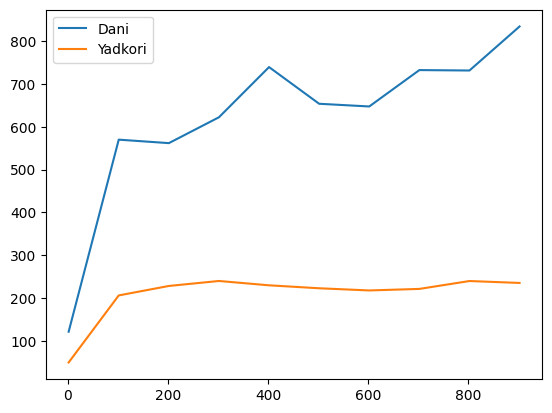

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
Array = np.ndarray


def lin_ucb_yadkori(bandit, n_step, lam=0.1, delta=0.0001, seeds=10):
    # Yadkori 2011の信頼集合を使った手法です
    regrets = []
    k = len(bandit.arms)
    d = bandit.feature_dim
    for _ in range(seeds):
        bandit.reset()
        arms = bandit.arms  # k x d
        Vt = lam * np.eye(d)
        theta_hat = np.zeros(d)
        AX = np.zeros((d, 1))
        pseudo_regret = 0
        for i in range(n_step):
            # UCBスコアの計算。
            sqrt_beta_t = np.sqrt(lam) + np.sqrt(2 * np.log(1 / delta) + d * np.log((d * lam + (i+1)) / (d * lam)))
            beta_t = sqrt_beta_t ** 2
            theta_a = arms @ theta_hat  # k
            Vt_inv = np.linalg.inv(Vt)
            beta_a_norm = beta_t * np.array([arm @ Vt_inv @ arm for arm in arms])
            ucb = theta_a + beta_a_norm

            # UCBスコアが最大のアームを選択
            arm = np.argmax(ucb)
            mean, rew = bandit.pull(arm)

            # 結果の記録
            pseudo_regret += bandit.optimal_mean - mean
            arm = arms[arm].reshape(d, 1)
            Vt += arm @ arm.T
            AX += arm * rew
            theta_hat = (np.linalg.inv(Vt) @ AX).reshape(-1)
            assert Vt.shape == (d, d)
            assert AX.shape == (d, 1)
    
        regrets.append(pseudo_regret)
    return np.mean(regrets)


def lin_ucb_dani(bandit, n_step, lam=0.1, delta=0.0001, seeds=10):
    # Dani 2008の信頼集合を使った手法です
    regrets = []
    k = len(bandit.arms)
    d = bandit.feature_dim
    for _ in range(seeds):
        bandit.reset()
        arms = bandit.arms  # k x d
        Vt = lam * np.eye(d)
        theta_hat = np.zeros(d)
        AX = np.zeros((d, 1))
        pseudo_regret = 0
        for i in range(n_step):
            # UCBスコアの計算。
            sqrt_beta_t = max(np.log((i+1)**2 / delta), np.sqrt(d * np.log(i+1) * np.log((i+1)**2 / (delta))))
            beta_t = sqrt_beta_t ** 2
            theta_a = arms @ theta_hat  # k
            Vt_inv = np.linalg.inv(Vt)
            beta_a_norm = beta_t * np.array([arm @ Vt_inv @ arm for arm in arms])
            ucb = theta_a + beta_a_norm

            # UCBスコアが最大のアームを選択
            arm = np.argmax(ucb)
            mean, rew = bandit.pull(arm)

            # 結果の記録
            pseudo_regret += bandit.optimal_mean - mean
            arm = arms[arm].reshape(d, 1)
            Vt += arm @ arm.T
            AX += arm * rew
            theta_hat = (np.linalg.inv(Vt) @ AX).reshape(-1)
            assert Vt.shape == (d, d)
            assert AX.shape == (d, 1)
    
        regrets.append(pseudo_regret)
    return np.mean(regrets)


class StochasticLinearBandit:
    def __init__(self, k: int, d: int, noise_scale: float):
        self.k = k
        self.d = d
        self.noise_scale = noise_scale
        self.theta_star = np.random.uniform(0, 1, size=(d,))
        self.arms = np.random.uniform(0, 1, size=(k, d))
        self.optimal_mean = np.max(self.arms @ self.theta_star)
        self.feature_dim = self.arms.shape[1]

    def reset(self):
        self.theta_star = np.random.uniform(0, 1, size=(self.d,))
        self.arms = np.random.uniform(0, 1, size=(self.k, self.d))
        self.optimal_mean = np.max(self.arms @ self.theta_star)

    def pull(self, arm):
        A = self.arms[arm]
        assert A.shape == (d,)
        assert self.theta_star.shape == (d,)
        mean = self.theta_star @ A
        noise = np.random.randn() * self.noise_scale
        reward = mean + noise
        return mean, reward


n_step = 1000
d = 5
dani_regrets = []
yadkori_regrets = []
num_arms = []
for k in tqdm(range(2, 1000, 100)):
    num_arms.append(k)
    bandit = StochasticLinearBandit(k, d, 1.0)
    dani_regrets.append(lin_ucb_dani(bandit, n_step, seeds=10))
    yadkori_regrets.append(lin_ucb_yadkori(bandit, n_step, seeds=10))

plt.plot(num_arms, dani_regrets, label="Dani")
plt.plot(num_arms, yadkori_regrets, label="Yadkori")
plt.legend()

